In [1]:
import time
import pandas as pd
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model

In [8]:
df_volume = pd.read_csv('data/output.csv') # Path: data\output.csv
df_volume.dtypes


SUBJECT_ID      int64
CHARTTIME      object
VALUE         float64
HAVEAKI         int64
dtype: object

In [9]:
unique_subject_ids = df_volume['SUBJECT_ID'].nunique()
print(f'There are {unique_subject_ids} unique SUBJECT_ID in df_volume.')

There are 2043 unique SUBJECT_ID in df_volume.


In [3]:
df_volume = df_volume.to_numpy()
#subject_id、尿量、ans
df_volume = np.array([df_volume[:,0], df_volume[:,2], df_volume[:,3]])
# 找出筆數大於等於36的病人
check = []
for key, val in Counter(df_volume[0]).items():
    if val >= 36:
        check.append(key)

# 病人後接上尿量、ans
Dictionary = {}
for i in range(len(df_volume[0])):
    if df_volume[0][i] in check:
        if df_volume[0][i] not in Dictionary:
            Dictionary[df_volume[0][i]] = [[df_volume[1][i], df_volume[2][i]]]
        else:
            Dictionary[df_volume[0][i]].append([df_volume[1][i], df_volume[2][i]])

def Filter1(x):
    li = []
    for i in x:
        li.append(int(i[0]))
    return li

#六小時內會有發生AKI output=1
def Filter2(x):
    li = []
    for i in x:
        li.append(i[1])
    for j in li:
        if j == 1:
            return 1
        else:
            return 0

data = []
ans = []
sequence_length = 36
for key, val in Dictionary.items():
    for index in range(len(val) - sequence_length):
        data.append(Filter1(val[index: index+sequence_length-6])) #1~30
        ans.append(Filter2(val[index+31: index+sequence_length]))


In [4]:
X_train, x_test, Y_train, y_test = train_test_split(data, ans, test_size=0.2)

In [5]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],1))
Y_train = Y_train.reshape((Y_train.shape[0], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1],1))
y_test = y_test.reshape((y_test.shape[0], 1))

In [7]:
print("訓練資料總數:",X_train.shape)
print("測試資料總數:",x_test.shape)
print("訓練答案總數:",Y_train.shape)
print("測試答案總數:",y_test.shape)
print(len(check))  #病人數


訓練資料總數: (438155, 30, 1)
測試資料總數: (109539, 30, 1)
訓練答案總數: (438155, 1)
測試答案總數: (109539, 1)
2012


In [55]:
# # AISTACK jupyter notebook used
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 24, 32)            256       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 8, 32)            0         
 1D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 8, 32)             0         
                                                                 
 lstm_6 (LSTM)               (None, 8, 50)             16600     
                                                                 
 dropout_7 (Dropout)         (None, 8, 50)             0         
                                                                 
 lstm_7 (LSTM)               (None, 50)                20200     
                                                      

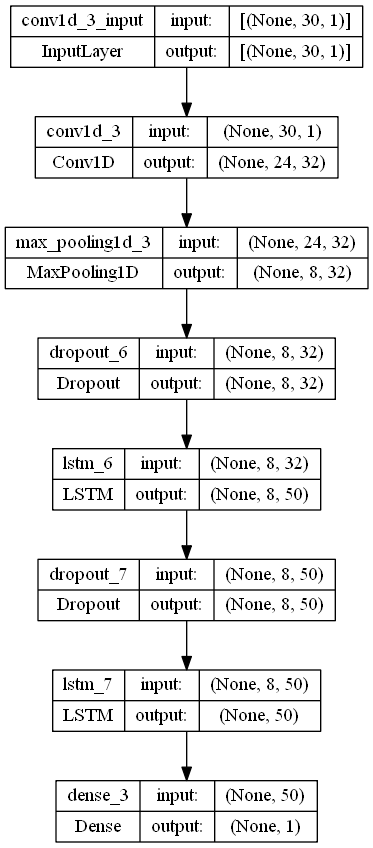

In [56]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers


#model
model = tf.keras.Sequential()
model.add(layers.Conv1D(filters=32, kernel_size=7, activation='relu', input_shape=(X_train.shape[1], 1), strides=1, padding='valid', kernel_regularizer=l2(0.01)))
model.add(layers.MaxPooling1D(3))
model.add(layers.Dropout(0.3))
model.add(layers.LSTM(50,return_sequences=True))
model.add(layers.Dropout(0.3))
model.add(layers.LSTM(50))
model.add(layers.Dense(1, activation='sigmoid')) 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


early_stop = EarlyStopping(monitor='val_loss', patience=10)

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [57]:
from sklearn.utils import class_weight

#class_weight
class_weight_dict = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(Y_train), y=Y_train.flatten())
class_weight_dict = dict(enumerate(class_weight_dict))


# model dir
model_dir = 'model/'
os.makedirs(model_dir, exist_ok=True)
log_dir = os.path.join(model_dir, 'logs', 'model_CNNLSTM_1')
model_cbk = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = tf.keras.callbacks.ModelCheckpoint(model_dir + 'Best_model_CNNLSTM_1.h5',
                                                monitor='val_accuracy',
                                                save_best_only=True,
                                                mode='max',
                                                early_stop=early_stop)

history = model.fit(X_train, Y_train, epochs=300, batch_size=128, validation_data=(x_test, y_test), callbacks=[model_cbk, model_mckp], class_weight=class_weight_dict)


Epoch 1/300


KeyboardInterrupt: 

In [ ]:
model.load_weights('model/Best_model_CNNLSTM_1.h5')
model.evaluate(x_test, y_test)


3424/3424 [==============================] - 24s 7ms/step - loss: 0.0745 - accuracy: 0.9792


[0.07450901716947556, 0.9791672229766846]

3424/3424 [==============================] - 23s 7ms/step


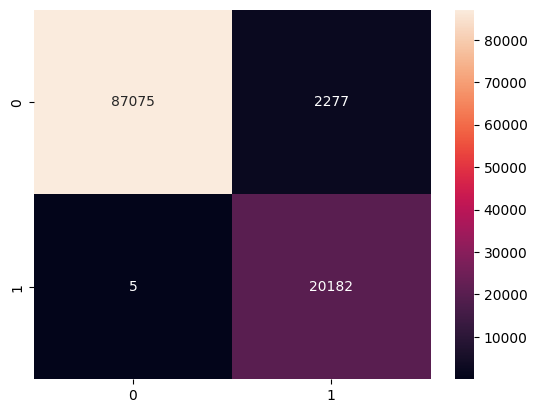

In [ ]:
#混淆矩陣
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(x_test)
y_pred = np.round(y_pred)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()


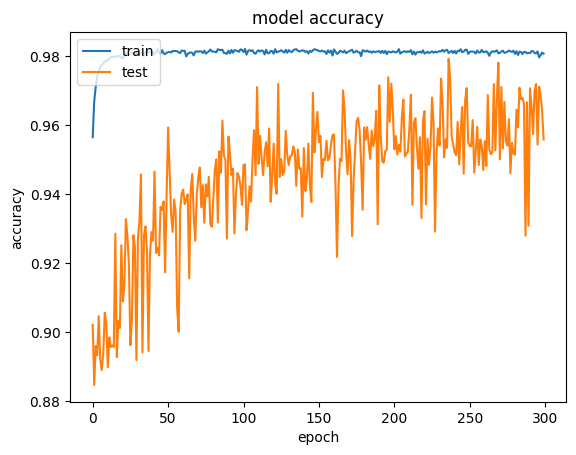

In [ ]:
#draw acc 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



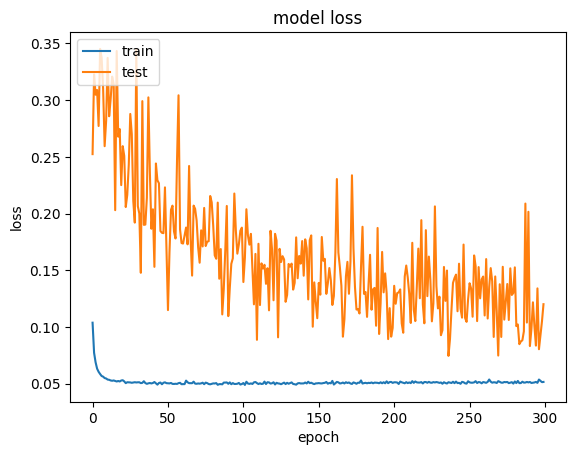

In [ ]:
#draw loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


3424/3424 [==============================] - 22s 6ms/step


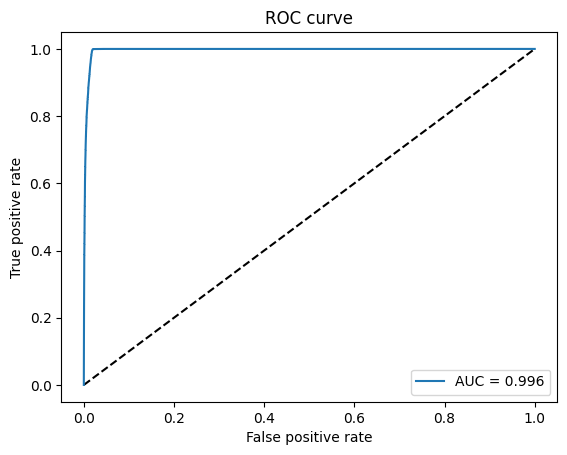

In [ ]:
#ROC
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


y_pred = model.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = auc(fpr, tpr)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()



In [ ]:
#f1 score picture
from sklearn.metrics import f1_score

y_pred = model.predict(x_test)
y_pred = np.round(y_pred)
f1 = f1_score(y_test, y_pred)
f1 = np.round(f1, 3)
print(f1)


3424/3424 [==============================] - 22s 7ms/step
0.946
